# Classifying names with a character-level RNN

## prep the data

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn' and c in all_letters)

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Arabic.txt', 'data/names/Chinese.txt', 'data/names/Czech.txt', 'data/names/Dutch.txt', 'data/names/English.txt', 'data/names/French.txt', 'data/names/German.txt', 'data/names/Greek.txt', 'data/names/Irish.txt', 'data/names/Italian.txt', 'data/names/Japanese.txt', 'data/names/Korean.txt', 'data/names/Polish.txt', 'data/names/Portuguese.txt', 'data/names/Russian.txt', 'data/names/Scottish.txt', 'data/names/Spanish.txt', 'data/names/Vietnamese.txt']
Slusarski


In [2]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


## Turning names into tensors

To make a word we join a bunch of those into a 2D matrix `<line_length x 1 x n_letters>`.

That extra 1 dimension is because PyTorch assumes everything is in batches - we’re just using a batch size of 1 here.

In [3]:
import torch

# Find letter index from all_letters, e.g., "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)


# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor


# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor


print(letterToTensor('J'))

print(lineToTensor('Jones').size())




Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 13 to 25 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 26 to 38 
    0     0     0     0     0     0     0     0     0     1     0     0     0

Columns 39 to 51 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 52 to 56 
    0     0     0     0     0
[torch.FloatTensor of size 1x57]

torch.Size([5, 1, 57])


## Creating the network

In [4]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)



To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). We’ll get back the output (probability of each language) and a next hidden state (which we keep for the next step).

Remember that PyTorch modules operate on Variables rather than straight up Tensors.

In [5]:
input = Variable(letterToTensor('A'))
hidden = Variable(torch.zeros(1, n_hidden))
output, next_hidden = rnn(input, hidden)

For the sake of efficiency we don’t want to be creating a new Tensor for every step, so we will use lineToTensor instead of letterToTensor and use slices. This could be further optimized by pre-computing batches of Tensors.

In [6]:
input = Variable(lineToTensor('Albert'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input[0], hidden)
print(output)

Variable containing:

Columns 0 to 9 
-2.9048 -2.9415 -2.8626 -2.8294 -2.8106 -2.8808 -2.8611 -2.9265 -2.8977 -2.9230

Columns 10 to 17 
-2.9159 -2.9570 -2.8678 -2.9261 -2.8968 -2.8622 -2.9779 -2.8048
[torch.FloatTensor of size 1x18]



## Training
### Prepare for training

In [7]:
def categoryFromOutput(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Vietnamese', 17)


We will also want a quick way to get a training example (a name and its language):

In [8]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]


def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(lineToTensor(line))
    return category, line, category_tensor, line_tensor

In [9]:
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category = ', category, '/line = ', line)

category =  Irish /line =  Samuel
category =  Czech /line =  Hartl
category =  Korean /line =  Ko
category =  German /line =  Houk
category =  Italian /line =  Fabbro
category =  Vietnamese /line =  Lac
category =  Vietnamese /line =  Quach
category =  Irish /line =  Braden
category =  German /line =  Brodbeck
category =  Spanish /line =  Blanco


## Training the network

Now all it takes to train this network is show it a bunch of examples, have it make guesses, and tell it if it’s wrong.

For the loss function `nn.NLLLoss` is appropriate, since the last layer of the RNN is `nn.LogSoftmax`.

In [11]:
criterion = nn.NLLLoss()

Each training loop will:

*    Create input and target tensors
*    Create a zeroed initial hidden state
*    Read each letter in and
    *    Keep hidden state for next letter
*    Compare final output to target
*    Back-propagate
*    Return the output and loss



In [12]:
learning_rate = 0.005  # If set too high, it might explode. If set too low, it might not learn.

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)
    loss.backward()
    
    # Add parameters' gradients to their values, multiplied by Learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
    
    return output, loss.data[0]

Now we just have to run that with a bunch of examples. Since the `train` function returns both the output and loss we can print its guesses and also keep track of loss for plotting. Since there are 1000s of examples we print only every `print_every` examples, and take an average of the loss.

In [33]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    #return '%dm %ds' % (m, s)
    return '{}m {}s'.format(m, s)

start = time.time()


for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
    
    # Add current Loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 8.590090990066528s) 2.3513 Sarno / Italian ✓
10000 10% (0m 17.20864701271057s) 3.0993 Unkle / Arabic ✗ (German)
15000 15% (0m 25.726311922073364s) 0.3846 Rogalnikov / Russian ✓
20000 20% (0m 34.3602831363678s) 1.0568 Morrison / Scottish ✓
25000 25% (0m 42.59225583076477s) 0.4036 Yoshitomi / Japanese ✓
30000 30% (0m 51.14539194107056s) 1.3292 Di pietro / Italian ✓
35000 35% (0m 59.50315594673157s) 0.8550 Samaha / Japanese ✗ (Arabic)
40000 40% (1m 7.818262815475464s) 3.2848 Tomlin / Irish ✗ (English)
45000 45% (1m 16.071228981018066s) 0.4439 Rakhmilovich / Russian ✓
50000 50% (1m 24.18514084815979s) 1.3959 Mitchell / Scottish ✓
55000 55% (1m 32.434581995010376s) 0.1230 Cipriani / Italian ✓
60000 60% (1m 40.63950300216675s) 1.0244 Gil / Chinese ✗ (Korean)
65000 65% (1m 48.90031409263611s) 0.0198 Piccoli / Italian ✓
70000 70% (1m 57.10271406173706s) 1.5492 Goto / Portuguese ✗ (Japanese)
75000 75% (2m 5.428038120269775s) 4.0236 Trigg / Vietnamese ✗ (English)
80000 80% (2m 13.738

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

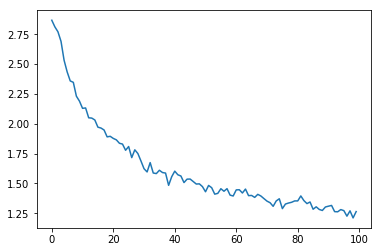

In [35]:
plt.figure()
plt.plot(all_losses)

## Evaluating the results

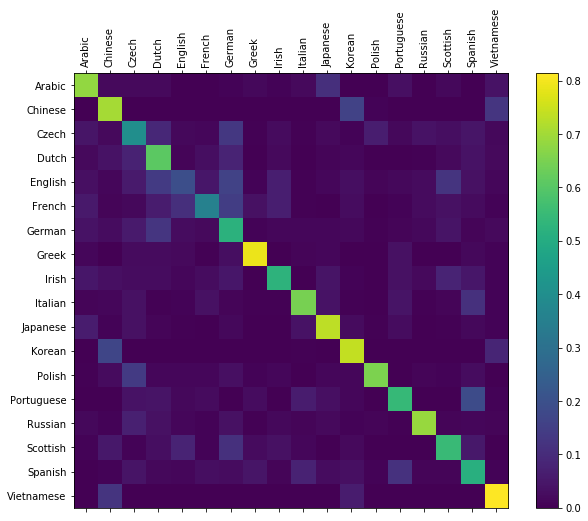

In [41]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, catgory_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1
    
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [42]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(lineToTensor(input_line)))
    
    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []
    
    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

In [43]:
predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.57) Russian
(-0.98) Czech
(-3.84) English

> Jackson
(-0.70) Scottish
(-1.69) English
(-2.31) Czech

> Satoshi
(-0.84) Italian
(-1.99) Japanese
(-2.27) Arabic
